In [48]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

figsize=(14, 5)

import numpy as np
from matplotlib import pyplot as plt
from util import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Iterated Projection

They say repetion is the mother of learning

## A Simple Constraint

**Let's consider a relatively simple constraint for binary classification**

$$
\sum_{i = 1}^{m} \mathop{\rm round}(\hat{y}_{i}) \leq (1 + \varepsilon) \frac{m}{2}
$$

* $\hat{y}_i$ is the estimated probability of class $i$
* $\mathop{\rm round}(\hat{y}_{i})$ is the corresponding rounded class
* The summation denotes the number of examples with class 1
* ...Which we require to be approximaly equal to 50%

**The restricton is synthetic and we'll use it just as an example**

* However, the example is stil practically relevant
* ...Since many fairness constraints in classification have the same structure!

<div class=big>
    How shall we tackle this constraint?
</div>

## ...And Yet an Annoying One

**We cannnot easily use Lagrangians**

...At least not in a differentiable ML setting

* The original constraint is non-differentiable when $\hat{y}_i = 0$
* ...And has 0-gradient everywhere else

This is all caused by the rounding operator

**We can obtain a _differentiable approximation_ by removing rounding**

$$
\sum_{i = 1}^{m} \hat{y}_{i} = \frac{m}{2}
$$

* But now we can satisfy the constraint by having $y_{i} = 0.5$ for all examples
* So, the constraint might conflict with the main loss function

## ...And Yet an Annoying One

**Projection has a better time dealing with non-differentiable constraints**

...But we cannnot easily use inference-time projection!

* This is a distribution constraint
* ...And cannot be enforced easily by working on individual examples

**Data projection might also be in trouble**

...Because it may fail to account for the input-output correlation

$$
\sum_{i = 1}^{m} \mathop{\rm round}(\hat{y}_{i}) \leq (1 + \varepsilon) \frac{m}{2}
$$

* There are many rounded vectors that satisfy the constraint
* ...And data projection might pick one that is uncorrelated with the input

<div class=big>
What can we do about this?<br>
    <small>First: at least give the know methods a chance! If that fails, however...</small>
</div>

## Moving Targets

**One way around these issues is provided by the [Moving Targets](https://www.aaai.org/AAAI21Papers/AAAI-9549.DetassisF.pdf) method**

...Which is designed for constrained _supervised_ learning, i.e.:

$$
\text{argmin}_{\theta} \left\{ L(\hat{y}, y) \mid y \in C \right\} \text{ with: } \hat{y} = f(x, \theta)
$$

* Where $\hat{y}$ is the prediction vector
* ...And $(x, y) = \{x_i, y_i\}_{i=1}^m$ is the training data

**The method alternates between _learner_ and _master_ steps**

* At evey step $k$, we keep a prediction $\hat{y}^{(k)}$ and a feasible _adjusted target $z^{(k)}$_
* In master steps, we _move $z^{(k)}$_ closer to te ground truth $y$
* In learner steps, we train an ML model to make $y^{(k)}$ close to $z$

## Moving Targets

**The _master step_ consists in solving:**

$$
z^{(k+1)} = \text{argmin}_{z} \left\{ L(z, y) + \frac{1}{\rho} L(\hat{y}^{(k)}, z) \mid z \in C \right\}
$$

We search for a $z$ vector such that:

* $z$ is close to $y$, as measured by the loss function $L$
* $z$ is feasible w.r.t. the constraints $C$

**Additionally, we keep $z$ close to the current prediction $\hat{y}^{(k)}$**

* We use the loss function to measure the proximity
* ...And we can control how close we want to stay by changing $\rho$

## Moving Targets

**The problem can be viewed as an approximate _proximal operator_**

$$
{\bf prox}_{\rho(I_C(z) + L(z, y))}(\hat{y}^{(k)})
$$

* $I_C(z)$ is the constraint indicator function for $C$
* ...And the operator is computed w.r.t. the current prediction $\hat{y}$

Applying the proximal operator would lead to:

$$
z^{(k+1)} = \text{argmin}_{z} \left\{ L(z, y) + \frac{1}{\rho} \|z - \hat{y}^{(k)}\|_2^2 \mid z \in C \right\}
$$

**This is similar to what we did in data projection**

* In the master step, the L2 norm is replaced by the loss function
* ...Exactly like in the data projection approach

## Moving Targets

**The problem can be viewed as an approximate _proximal operator_**

$$
{\bf prox}_{\rho (I_C(z) + L(z, y))}(\hat{y}^{(k)})
$$

* $I_C(z)$ is the constraint indicator function for $C$
* ...And the operator is computed w.r.t. the current prediction $\hat{y}$

Applying the proximal operator would lead to:

$$
z^{(k+1)} = \text{argmin}_{z} \left\{ L(z, y) + \frac{1}{\rho} \|z - \hat{y}^{(k)}\|_2^2 \mid z \in C \right\}
$$

**...With one key difference**

* We consider proximity w.r.t. the _prediction_ $\hat{y}^{(k)}$
* ...And we account for the loss w.r.t. the ground truth $y$

## Moving Targets

**In the _learner step_ we make the prediction closer to $z^{(k+1)}$**

Given a target vector $z^k$, this consists in solving:

$$
\hat{y}^{(k+1)} = \mathop{\rm argmin}_{\theta} L(\hat{y}, z^{(k+1)}) \quad \text{ with: } \hat{y} = f(x; \theta)
$$

...Which is just a _traditional supervised learning_ problem

**The step can _also_ be viewed as a form of projection:**

$$
\hat{y}^{(k+1)} = \text{argmin}_{\hat{y}} \left\{ L(\hat{y}, z^{(k+1)}) \mid \hat{y} \in B \right\} \text{ with: } B = \{\hat{y} \mid \exists \theta, \hat{y} = f(x; \theta) \}
$$

Where $B$ (model bias) is the set of output that can be reached by the model

* This perspective is useful to understand the algorithm behavior
* ...But of course it does not alter the way we train

## Moving Targets

**Overall, the method is as follows:**

* $y^{(0)} = \mathop{\rm argmin}_{\hat{y}} \left\{ L(\hat{y}, y) \mid \hat{y} \in B \right\}$
* For $k = 0..n-1$:
  - $z^{(k+1)} = \mathop{\rm argmin}_{z} \left\{ L(z, y) + \frac{1}{\rho} L(\hat{y}^{(k)}, z) \mid z \in C \right\}$
  - $\hat{y}^{(k+1)} = \text{argmin}_{\hat{y}} \left\{ L(\hat{y}, z^{(k+1)}) \mid \hat{y} \in B \right\}$

**Some highlights**

* You can use any technique for either step (it's a full decomposition)
* Non differentiable constraints can be handled via CP, SMT, MP, meta-heuristics
* Batching is not needed in the master step (when constraints are handled)
* $\alpha$ is divided by $k$ at each iteration to ensure convergence

## Moving Targets

**Overall, the method is as follows:**

* $y^{(0)} = \mathop{\rm argmin}_{\hat{y}} \left\{ L(\hat{y}, y) \mid \hat{y} \in B \right\}$
* For $k = 0..n-1$:
  - $z^{(k+1)} = \mathop{\rm argmin}_{z} \left\{ L(z, y) + \frac{1}{\rho} L(\hat{y}^{(k)}, z) \mid z \in C \right\}$
  - $\hat{y}^{(k+1)} = \text{argmin}_{\hat{y}} \left\{ L(\hat{y}, z^{(k+1)}) \mid \hat{y} \in B \right\}$

**Speaking of convergence**

* If $L, B, C$ are convex and target are continuous...
  - ...Then the method can be proved to converge to a global optimum
* When these conditions are not met
  - ...The method is _still applicable_ as a heuristic

<div class=big>
    Let's see a running example
</div>

## A Toy Learning Problem

**Say we want to fit a model in the form:**
$$
\tilde{f}(x, \beta) = x^\beta
$$
...Based on _just two observations_

**For evaluation purpose, we assume we know the true curve, i.e.:**
$$
f(x) = x^{0.579} 
$$
And hence we can obtain the true $y$ values:

In [2]:
xm = np.array([1.5, 3])
ym = np.array([1.2, 2.2])

f_true = lambda x: x**0.579
yt = f_true(xm)

## A Toy Learning Problem

**We can now plot both the true curve and the measured $x, y$ points:**

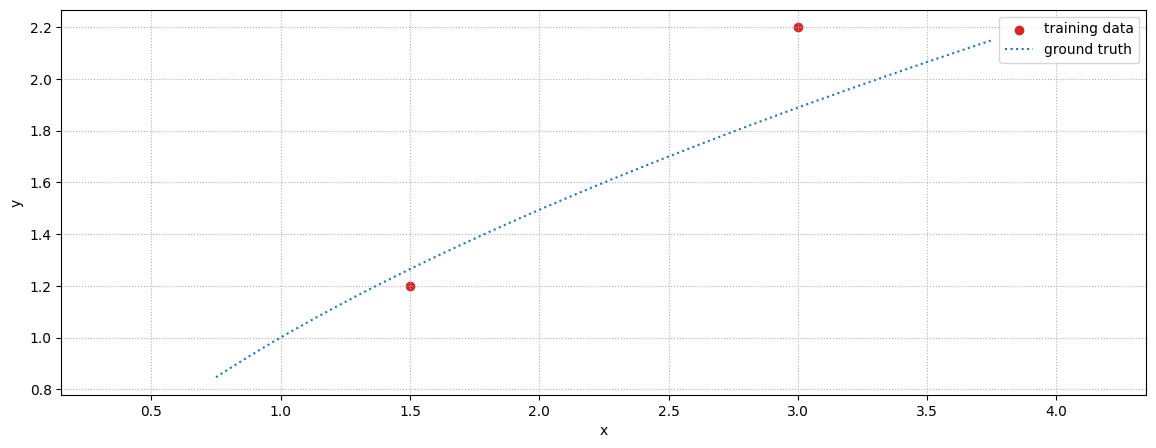

In [6]:
util.mtx_function_plot(xm, ym, f_true, figsize=figsize)

* We are underestimating the first point and overestimatng the second
* ...Which may easily trick our simple model

## Learner Step

**We can now perform the first learner step**

For this example, we can use any curve fitting method

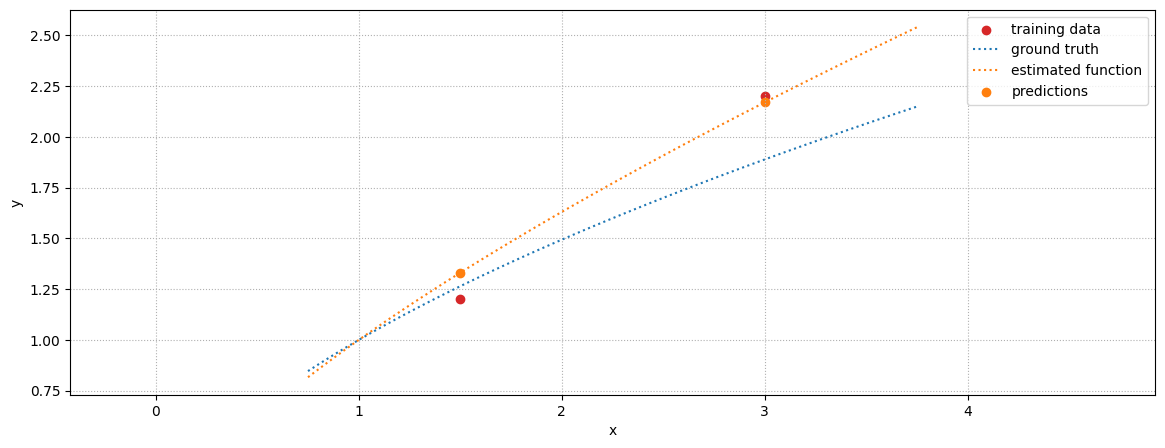

In [8]:
f_pred = util.mtx_learner_step(xm, ym)
util.mtx_function_plot(xm, ym, f_true, f_pred, figsize=figsize)

* The learner model indeed overestimates the curve slope
* More data could fix the issue, but we will rely instead on _constraints_

## Taking Advantage of Constraints

**Before that, let's view measurements and predictions in output space**

...Where they both look like _points_

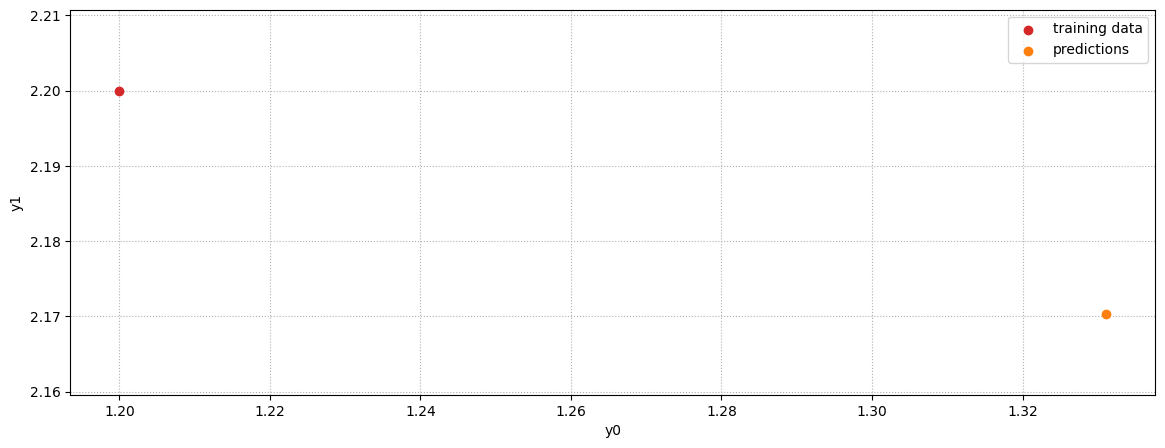

In [11]:
yp = f_pred(xm)
util.mtx_output_plot(xm, ym, yp, figsize=figsize)

## Visualizing Model Bias

**By changing the $\beta$ in our model we can change the prediction vector**

We can draw a range of potential predictions in output space (part of $B$)

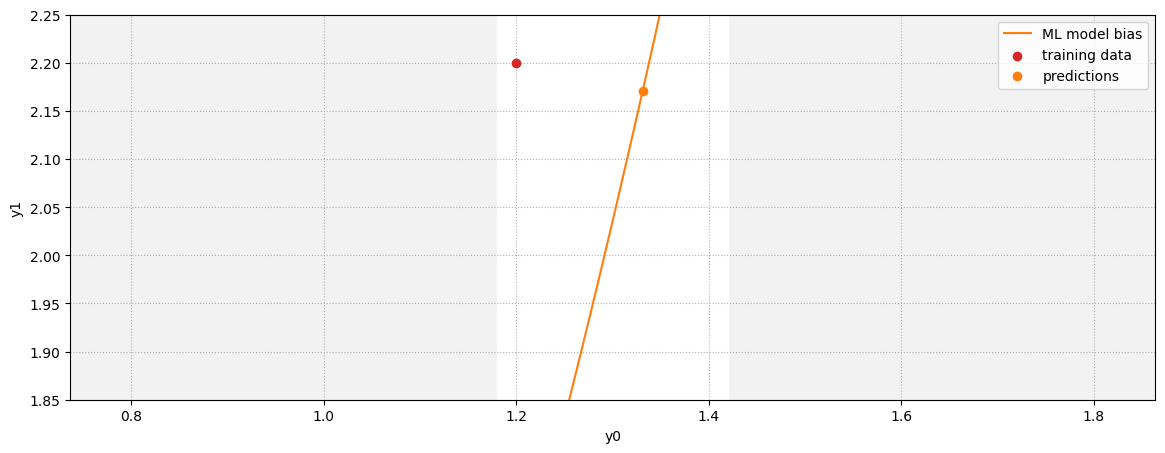

In [13]:
yp = f_pred(xm)
util.mtx_output_plot(xm, ym, yp, plot_bias=True, figsize=figsize, ylim=(1.85, 2.25))

* This represents the bias $B$ of our ML model

## Taking Advantage of Constraints

**Say we know that our two measurements must obey**
$$
y_1 \leq \frac{3}{2} y_0
$$

We can draw the feasible set $C$ in output space, too!

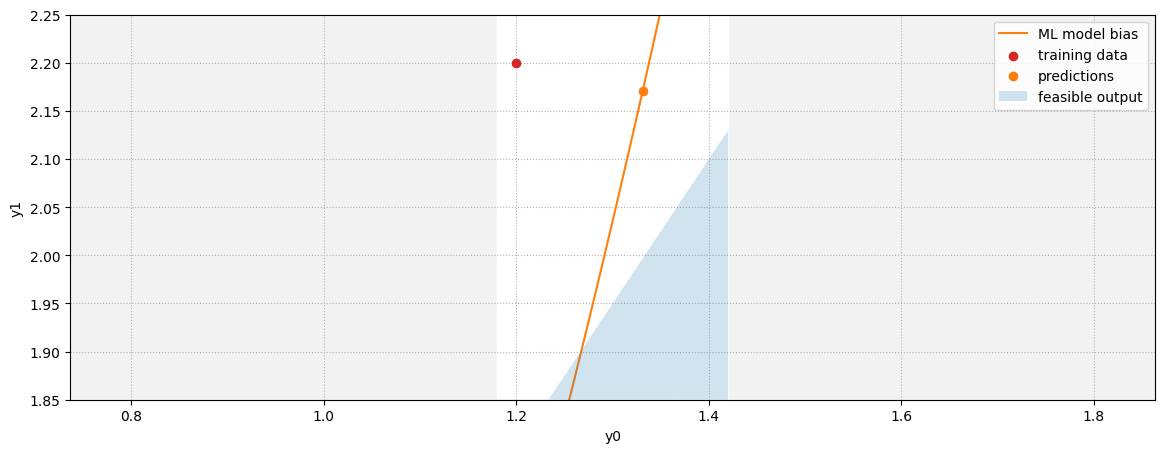

In [47]:
f_bound = lambda y0: 1.5*y0
util.mtx_output_plot(xm, ym, yp, plot_bias=True, f_bound=f_bound, figsize=figsize, ylim=(1.85, 2.25))

## Master Step

**We can now perform the first master step**

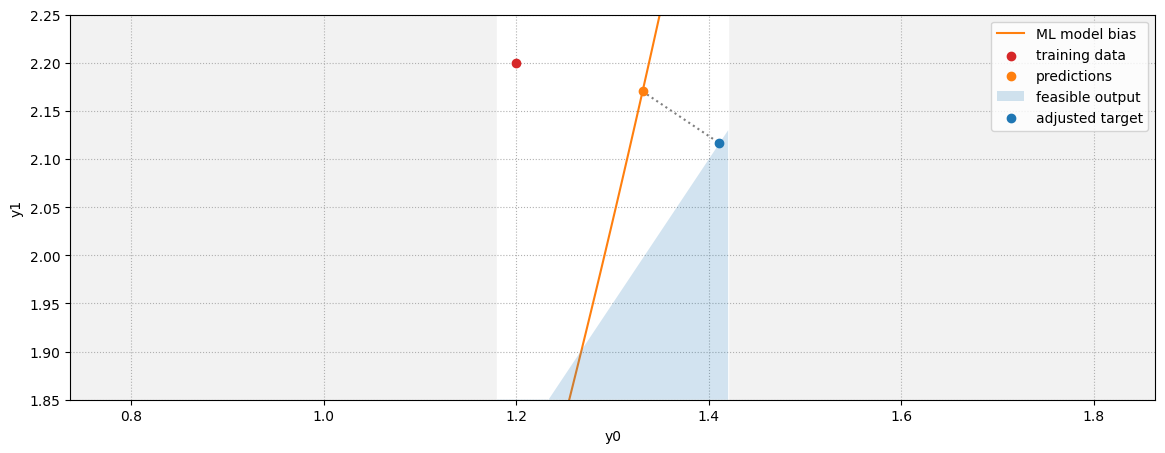

In [46]:
yf = util.mtx_master_step_alpha(ym, yp, rho=0.01)
util.mtx_output_plot(xm, ym, yp, plot_bias=True, f_bound=f_bound, yf=yf, figsize=figsize, ylim=(1.85, 2.25))

* The result is similar to a projection, but it is a bit closer to the true target

## Second Learner Step

**We can now perform and visualize a second learner step**

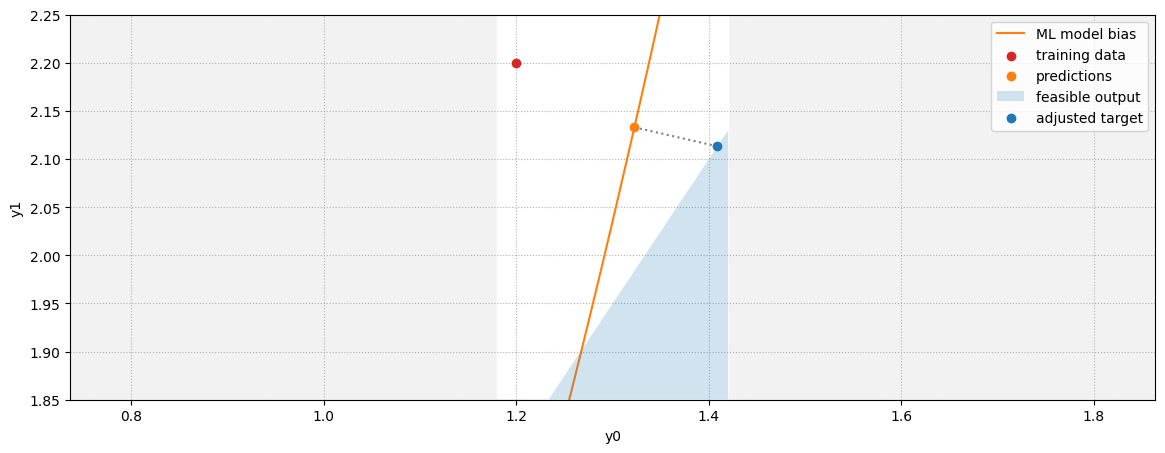

In [39]:
f_pred2 = util.mtx_learner_step(xm, yf)
yp2 = f_pred2(xm)
util.mtx_output_plot(xm, ym, yp2, plot_bias=True, f_bound=f_bound, yf=yf, figsize=figsize, ylim=(1.85, 2.25))

* This one is an actual projection on the model bias $B$

## The Full Method

**We can visualize a few iterations to see how MT works**

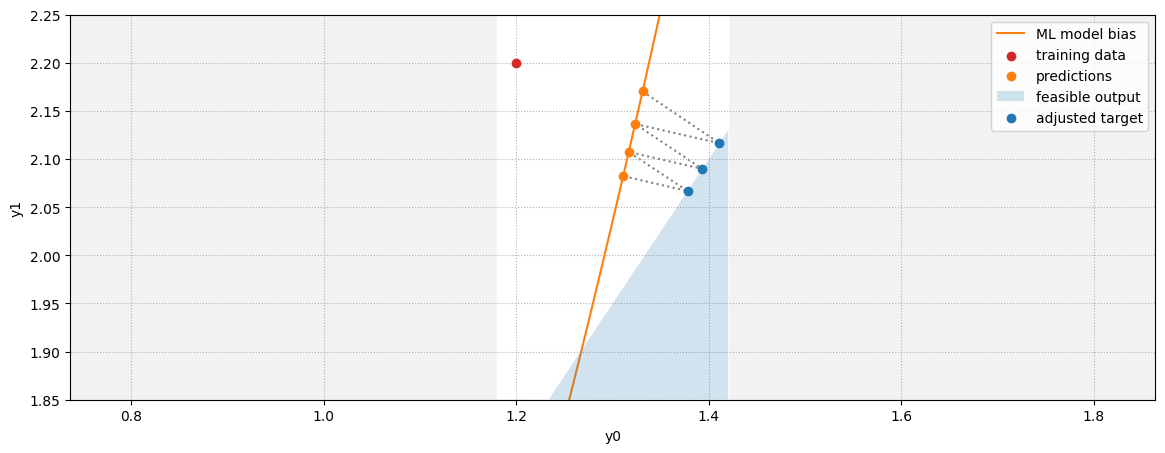

In [45]:
ypl, yfl, _ = util.mtx_moving_target_rho(xm, ym, n=3, rho=0.01)
util.mtx_output_plot(xm, ym, ypl, plot_bias=True, f_bound=f_bound, yf=yfl, figsize=figsize, ylim=(1.85, 2.25))

* Basically, MT zig-zags between the $B$ and the $C$ set
* This is not ideal, but it's the price we pay to enjoy a full decomposition

## The Final Outcome

**We can now inspect which kind of model we can obtain after some iterations**

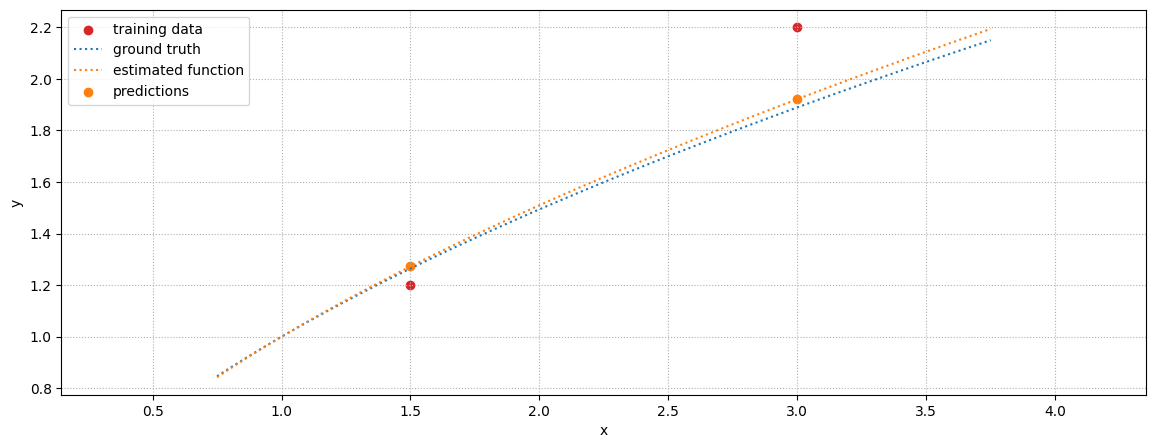

In [44]:
_, _, f_pred_final = util.mtx_moving_target_rho(xm, ym, n=30, rho=0.01)
util.mtx_function_plot(xm, ym, f_true, f_pred_final, figsize=figsize)

* This is very close to the true function!